In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression # must come before nest
import scipy.stats as st
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [108]:
def raised_cosine(n_bases, bin_size, end_peak_times, offset, stretching='log'):
    '''Raised cosine basis
      ^
     / \
    /   \______
         ^
        / \
    ___/   \___
            ^
           / \
    ______/   \
    Make log or linearly stretched basis consisting of raised cosines.
    Log stretching allows faster changes near the event.
    
    Parameters
    ----------
    n_bases : int
        Number of basis vectors
    bin_size : float
        time bin size (separation for representing basis
    end_peak_times : array
        [2 x 1] array containg [1st_peak,  last_peak], the peak
             (i.e. center) of the first and the last raised cosine basis vectors
    offset: float
        offset for log stretching of x axis:  y = log(t + offset)
        (larger offset -> more nearly linear stretching)
    stretching : str
        "log" or "linear"

    Returns
    -------
    time : array
        time lattice on which basis is defined
    bases : array
        basis itself
    centers : array
        centers of each basis function

    Example
    -------
    time, bases, centers = log_raised_cosine(10, 1, [0, 500], 2);
    '''
    if stretching == 'log':
        if offset <= 0:
            raise ValueError('offset must be greater than 0')
        #log stretching x axis (and its inverse)
        stretch = lambda x: np.log(x + 1e-20)
        inv_stretch = lambda x: np.exp(x) - 1e-20
    elif stretching == 'linear':
        stretch = lambda x: x
        inv_stretch = lambda x: x
        offset = 0
    else:
        raise ValueError('stretching must be "log" or "linear"')
    
    x_range = stretch(end_peak_times + offset)

    db = np.diff(x_range) / (n_bases - 1)  # spacing between raised cosine peaks

    centers = np.arange(x_range[0], x_range[1] + db / 2, db)  # centers for basis vectors

    max_time_bin = inv_stretch(x_range[1] + db) - offset  # maximum time bin (originally 2 * db)

    time = np.arange(0, max_time_bin, bin_size)
    
    centers_tiled = np.tile(centers, (time.size, 1))

    time_stretch_tiled = np.tile(stretch(time + offset)[:, np.newaxis], (1, n_bases))

    def _raised_cosine(time, centers, dc):
        center_adjusted = (time - centers) * np.pi / dc # originally divided by 2
        center_adjusted_min = np.minimum(np.pi, center_adjusted)
        center_adjusted_min_max = np.maximum(-np.pi, center_adjusted_min)
        return (np.cos(center_adjusted_min_max) + 1) / 2

    bases = _raised_cosine(time_stretch_tiled, centers_tiled, db)

    centers = inv_stretch(centers)

    return time, bases, centers

In [139]:
def prune(a, ref):
    b = np.concatenate(([False], np.diff(a) < ref))
    c = np.concatenate(([False], np.diff(b.astype(int)) > 0))
    d = a[~c]
    if any(np.diff(a) < ref):
        d = prune(d, ref)
    return d


def generate_stim_times(stim_rate, stim_isi_min, stop_time):
    stim_times = np.sort(np.random.uniform(
        0, stop_time, stim_rate * stop_time))
    return prune(stim_times, stim_isi_min)


def generate_neurons(stim_times, make_post=False, **p):
    n_stim = len(stim_times)
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    n_stim_spikes = int(n_stim * p['stim_hit_chance'])
    idxs_stim_spikes = idxs[:n_stim_spikes]

    spikes = np.sort(np.concatenate([
        st.norm.rvs(loc=stim_times[idxs_stim_spikes] + p['stim_latency'], scale=p['stim_latency_std']),
        np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time'])
    ]))
    pre_spikes = prune(spikes, p['refractory'])
    n_pre_spikes = len(pre_spikes)
    if make_post:
        n_post_spikes = int(n_pre_spikes * p['pre_hit_chance'])
        idxs_post_spikes = np.random.permutation(np.arange(n_pre_spikes).astype(int))[:n_post_spikes]

        post_spikes = np.sort(np.concatenate([
            st.norm.rvs(loc=pre_spikes[idxs_post_spikes] + p['latency'], scale=p['latency_std']),
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        post_spikes = prune(post_spikes, p['refractory'])
    
        return pre_spikes, post_spikes
    else:
        return pre_spikes

In [140]:
# def OLS(X, y):
#     dot, inv = np.dot, np.linalg.inv
#     return dot(dot(inv(dot(X.T, X)), X.T), y)


# def calculate_regressors(x, y, stim_times, latency, winsize):
#     stim_times = stim_times.astype(float)
    
#     src_x = np.searchsorted(x, stim_times, side='right')
    
#     remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
#     src_x = np.delete(src_x, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)
#     Z = x[src_x-1] - stim_times
#     X = x[src_x] - stim_times
    
#     stim_win = np.insert(
#         stim_times + latency, 
#         np.arange(len(stim_times)) + 1, 
#         stim_times + latency + winsize)
#     src_y = np.searchsorted(y, stim_win, side='left')
#     cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
#     Y = cnt_y.flatten()
#     return Z, X, Y


# def IV(x, y, stim_times, latency, winsize): # OLS
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     W = OLS(Z, X)

#     X_hat = np.dot(Z, W)
    
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV


# def IV(x, y, stim_times, latency, winsize):
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     X = ((X > 0.001) & (X < 0.003)).astype(int)
#     Z = Z.reshape(-1, 1)
    
#     model = LogisticRegression(C=1e5, solver='lbfgs')# max_iter=1000)#, solver='liblinear')

#     model.fit(Z, X)
#     X_hat = model.predict(Z)
    
#     from scipy.special import expit

#     plt.scatter(Z.ravel(), X, color='black', zorder=20)

# #     plt.scatter(Z.ravel(), X_hat, color='blue', zorder=20)

#     X_test = np.linspace(min(Z), 0, 300)


#     loss = expit(X_test * model.coef_ + model.intercept_).ravel()
#     plt.plot(X_test, loss, color='red', linewidth=3)
    
# #     plt.xlim(-30e-3,0)
    
#     X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
#     beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
#     return beta_IV


def calculate_regressors(x, y, stim_times, y_mu, y_sigma):
    stim_times = stim_times.astype(float)
    
    src_x = np.searchsorted(x, stim_times, side='right')
    
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    stim_win = np.insert(
        stim_times + y_mu - y_sigma, 
        np.arange(len(stim_times)) + 1, 
        stim_times + y_mu + y_sigma)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Z, X, Y


def IV(x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, n_bases=20, bin_size=1e-3, offset=1e-2):
            
    Z, X, Y = calculate_regressors(x, y, stim_times, y_mu, y_sigma)
    
    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
    Z = np.abs(Z)
    max_time = Z.max()
    
    time, bases, centers = raised_cosine(n_bases, bin_size, np.array([0, max_time]), offset)
    Z_bases = np.zeros((len(Z), n_bases))

    def index(t, bin_size):
        return np.ceil(t / bin_size).astype(int)

    idxs = index(Z, bin_size)
    Z_bases[:, :] = bases[idxs, :]
    

    model = LogisticRegression(C=1e5, solver='liblinear')
    model.fit(Z_bases, X)
    X_hat = model.predict(Z_bases)
    
    X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
    beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
    return beta_IV

# single case

In [141]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count


def fit_latency(pre, post, binsize=.1e-3, limit=[-10e-3, 20e-3], init=[5e-4, 5e-4], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, *p)
    error  = lambda p, x, y: (y - normpdf(p, x))
    res, _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf(res, b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.3f} $\sigma$ {:.3f}'.format(*res))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return res

In [164]:
np.random.seed(1234)

stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 30e-3, # minimum inter stimulus interval
}
neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 4e-3, # post response delay
    'latency_std': 1e-3,
    'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
    'stim_latency': 2e-3, # latency from stim to pre response
    'stim_latency_std': .5e-3,
    'stop_time': stim_params['stop_time'],
}
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 6e-3,
    'y_sigma': 2e-3,
    'n_bases': 20,
    'bin_size': 1e-3,
    'offset': 1e-2
}

stim_times = generate_stim_times(**stim_params)

x, y = generate_neurons(stim_times, make_post=True, **neuron_params)
xx = generate_neurons(stim_times, make_post=False, **neuron_params)
print(len(stim_times))

31620


In [165]:
IV(x, y, stim_times, **iv_params), IV(xx, y, stim_times, **iv_params)

(0.4136078047993868, -0.042034323520312424)

In [112]:
Z, X, Y = calculate_regressors(x, y, stim_times, **iv_params)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Poisson generated')

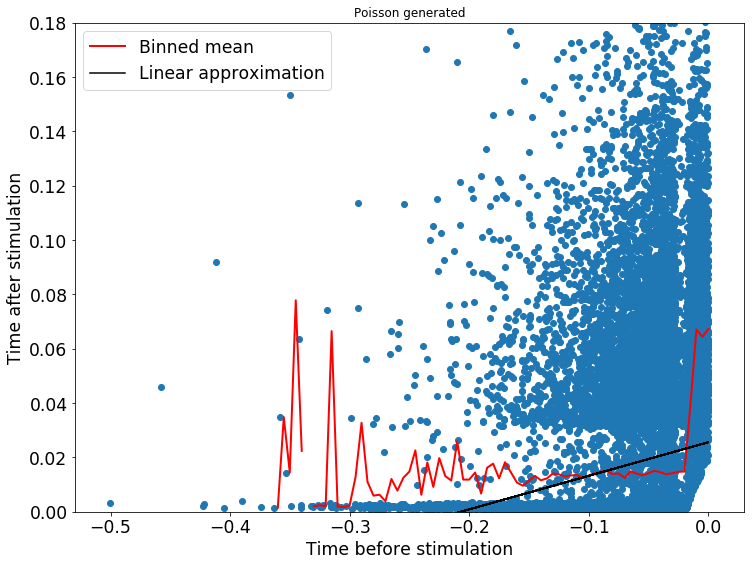

In [72]:
plt.scatter(Z, X)

a, b, c = st.binned_statistic(Z, X, statistic='mean', bins=100)

plt.plot(b[1:], a, c='r', lw=2, label='Binned mean')

plt.ylim(0, .18)

ZZ = np.vstack((Z, np.ones(Z.shape[0]))).T

XX = np.vstack((X, np.ones(X.shape[0]))).T

W = OLS(ZZ, XX)

X_hat = np.dot(ZZ, W)

plt.plot(Z, X_hat[:,0], 'k', label='Linear approximation')

plt.xlabel('Time before stimulation')

plt.ylabel('Time after stimulation')

plt.legend()

plt.title('Poisson generated')

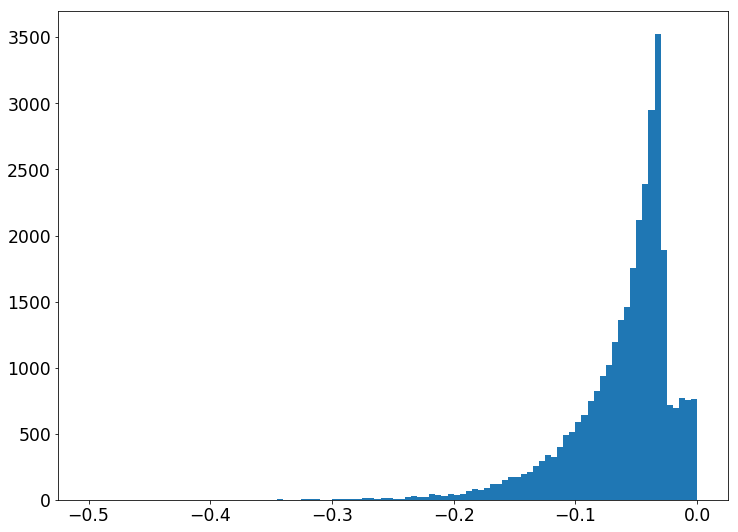

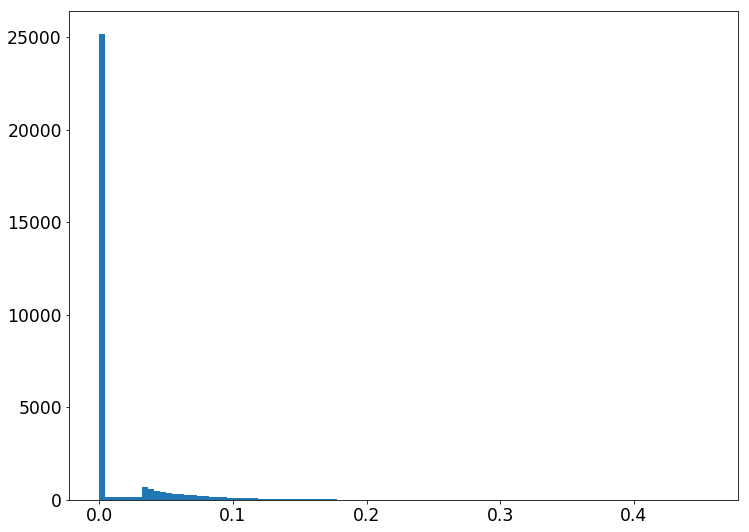

In [53]:
bins = 100#np.arange(-.1, 0, 1e-3)
plt.hist(Z, bins=bins);

plt.figure()
bins = 100#np.arange(0, 0.01, 1e-4)
plt.hist(X, bins=bins);

array([0.00604782, 0.0012074 ])

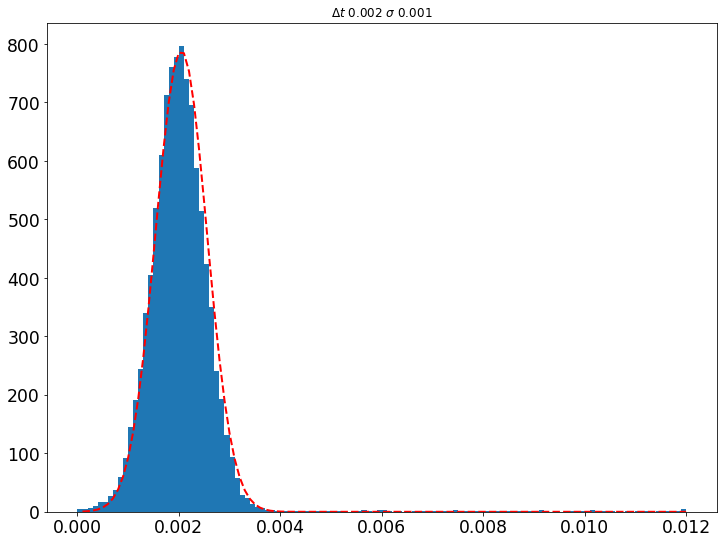

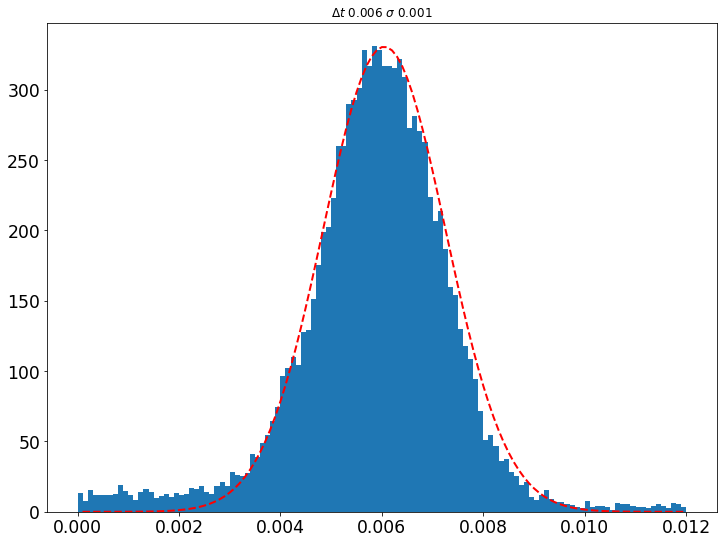

In [151]:
fit_latency(stim_times, x, limit=[0, 12e-3], plot=True)
plt.figure()
fit_latency(stim_times, y, limit=[0, 12e-3], plot=True)

# Increasing hit chance A -> C

In [174]:
np.random.seed(1234)
results = []
for h in tqdm(np.arange(0, 1.1, .1)):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
        'latency_std': 1e-3,
        'pre_hit_chance': h, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
        'stim_latency_std': .5e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'x_mu': 2e-3,
        'x_sigma': 1e-3,
        'y_mu': 6e-3,
        'y_sigma': 2e-3,
        'n_bases': 20,
        'bin_size': 1e-3,
        'offset': 1e-2
    }


    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,bin_size,latency,latency_std,...,stim_hit_chance,stim_isi_min,stim_latency,stim_latency_std,stim_rate,stop_time,x_mu,x_sigma,y_mu,y_sigma
0,17.0995,17.0490,-0.0825,4.9175,15.8100,0.003876,-0.001174,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
1,17.0290,17.0640,1.5410,6.5410,15.7995,0.037383,-0.000542,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
2,17.0525,17.0545,3.1805,8.1805,15.7835,0.106418,0.023973,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
3,16.9845,16.9825,4.8150,9.8150,15.7070,0.136271,0.003922,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
4,17.0615,17.0325,6.4515,11.4515,15.7860,0.225679,-0.002371,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
5,16.9735,17.0015,8.0420,13.0420,15.7325,0.228656,-0.019975,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
6,17.0515,17.0690,9.7015,14.7015,15.8000,0.257384,-0.000902,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
7,17.0765,17.0625,11.3500,16.3500,15.7995,0.328205,-0.027730,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
8,17.0120,17.0215,12.9260,17.9260,15.7635,0.409542,0.007494,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002
9,16.9950,16.9480,14.5455,19.5455,15.6875,0.428530,-0.012048,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,2000,0.002,0.001,0.006,0.002


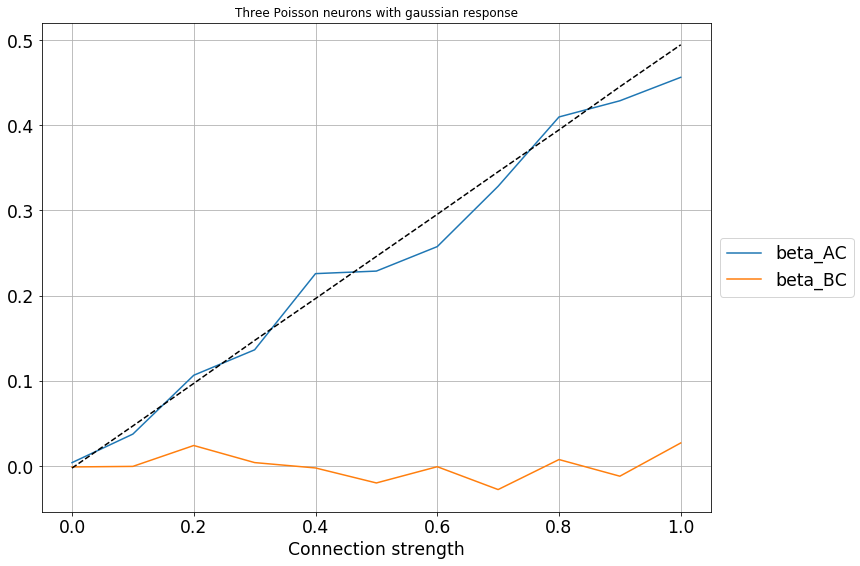

In [178]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
#     'C_induced_rate'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.plot(results['pre_hit_chance'], results.C_induced_rate / (results.A_rate + results.S_rate), '--k')

plt.title('Three Poisson neurons with gaussian response')
plt.xlabel('Connection strength')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Increasing stop time

In [179]:
results_stop_time = []
for h in tqdm(np.arange(100, 6100, 10)):
    stim_params = {
        'stop_time': h, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
        'latency_std': 1e-3,
        'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
        'stim_latency_std': .5e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'x_mu': 2e-3,
        'x_sigma': 1e-3,
        'y_mu': 6e-3,
        'y_sigma': 2e-3,
        'n_bases': 20,
        'bin_size': 1e-3,
        'offset': 1e-2
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results_stop_time.append({**stim_params, **neuron_params, **iv_params, **res})
    
results_stop_time = pd.DataFrame(results_stop_time)
results_stop_time.head()

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,bin_size,latency,latency_std,...,stim_hit_chance,stim_isi_min,stim_latency,stim_latency_std,stim_rate,stop_time,x_mu,x_sigma,y_mu,y_sigma
0,17.040000,17.000000,12.980000,17.980000,15.810000,0.278515,0.119140,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,100,0.002,0.001,0.006,0.002
1,17.036364,17.109091,13.018182,18.018182,15.927273,0.381852,-0.078566,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,110,0.002,0.001,0.006,0.002
2,17.116667,17.083333,13.058333,18.058333,15.808333,0.352878,-0.135247,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,120,0.002,0.001,0.006,0.002
3,16.984615,17.030769,12.823077,17.823077,15.753846,0.452347,-0.096494,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,130,0.002,0.001,0.006,0.002
4,16.992857,17.050000,12.828571,17.828571,15.800000,0.348075,-0.046269,0.001,0.004,0.001,...,0.8,0.03,0.002,0.0005,30,140,0.002,0.001,0.006,0.002


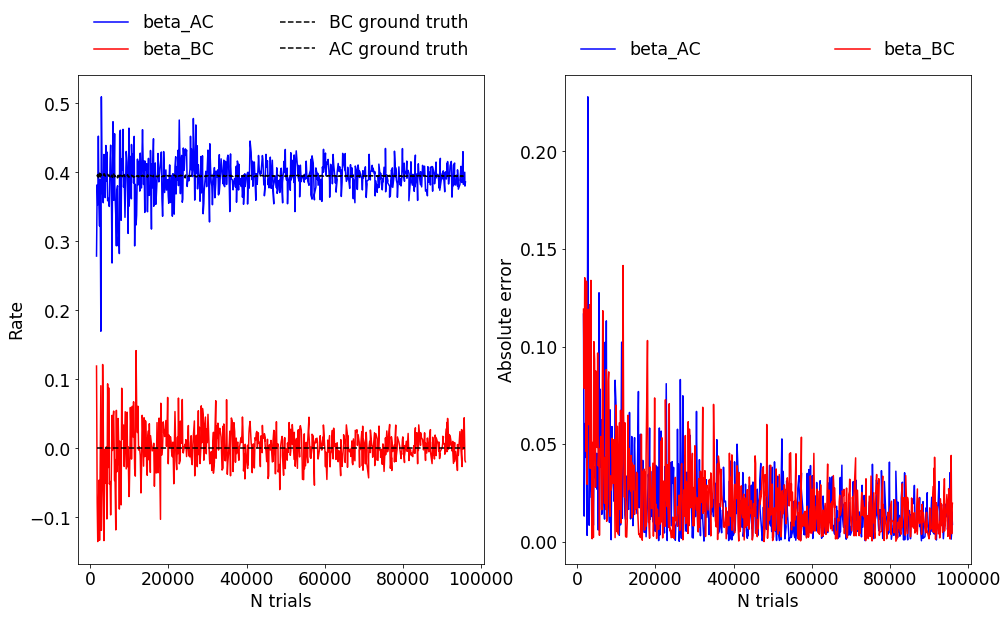

In [188]:
fig, (ax_v, ax_e) = plt.subplots(1, 2, figsize=(16, 9))

AC_ground_truth = results_stop_time.C_induced_rate / (results_stop_time.A_rate + results_stop_time.S_rate)
BC_ground_truth = np.zeros(len(results_stop_time['stop_time']))

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    results_stop_time['beta_AC'], 
    color='b')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    results_stop_time['beta_BC'], 
    color='r')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    BC_ground_truth, '--k',
    label='BC ground truth')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    AC_ground_truth, '--k',
    label='AC ground truth')

ax_e.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    abs(results_stop_time['beta_AC'] - AC_ground_truth), 
    label='beta_AC', color='b')

ax_e.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    abs(results_stop_time['beta_BC'] - 0), 
    label='beta_BC', color='r')

ax_v.set_xlabel('N trials')
ax_e.set_xlabel('N trials')
ax_e.set_ylabel('Absolute error')
ax_v.set_ylabel('Rate')

ax_v.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

ax_e.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

# ax_v.set_ylim(-100, 100)
# ax_e.set_ylim(0, 100)